In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from collections import defaultdict

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

DIR_WEIGHTS = '/kaggle/input/global-wheat-detection-public'

#WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn_best.pth'

DIR_INPUT = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'
%load_ext autotime

In [2]:
DIR_TEST
#/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/test

'/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/test'

time: 2.23 ms


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

time: 2.1 ms


In [4]:
DIR_INPUT

'/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection'

time: 3.08 ms


In [5]:
test_df = pd.read_csv('/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/test.csv')
test_df.shape

(214, 5)

time: 6.22 ms


In [6]:
test_df

,image_id,width,height,bbox,source
0,f5a1f0358.jpg,1024,1024,"[121.0, 204.0, 108.0, 147.0]",usack_1
1,f5a1f0358.jpg,1024,1024,"[216.0, 288.0, 127.0, 130.0]",usack_1
2,f5a1f0358.jpg,1024,1024,"[49.0, 449.0, 184.0, 154.0]",usack_1
3,f5a1f0358.jpg,1024,1024,"[280.0, 445.0, 176.0, 111.0]",usack_1
4,f5a1f0358.jpg,1024,1024,"[455.0, 292.0, 92.0, 216.0]",usack_1
...,...,...,...,...,...
209,2fd875eaa.jpg,1024,1024,"[917.0, 644.0, 98.0, 78.0]",usack_1
210,2fd875eaa.jpg,1024,1024,"[867.0, 56.0, 129.0, 104.0]",usack_1
211,2fd875eaa.jpg,1024,1024,"[698.0, 114.0, 119.0, 121.0]",usack_1
212,2fd875eaa.jpg,1024,1024,"[894.0, 852.0, 72.0, 149.0]",usack_1


time: 8.38 ms


In [7]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        #print('records->',f'{self.image_dir}/{image_id}')
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

time: 1.75 ms


In [8]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

time: 2.6 ms


In [9]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

time: 563 ms


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
# Load the trained weights
model.load_state_dict(torch.load('/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'))
model.eval()#x = model.to(device)

cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

time: 1.5 s


In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

time: 1.41 ms


In [12]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

time: 13.9 ms


In [13]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        #true_boxes = np.array([[i[0],i[1],i[0]+i[2],i[1]+i[3]] for i in true_boxes])
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        #print('boxesA->',boxes)
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            #print('image->',image.shape,type(image))
            #print('target-boxes->',target['boxes'])
            
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

time: 2.81 ms


In [14]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    #print('images->',images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

/home/jake/venv/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


time: 740 ms


In [15]:
#test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
#test_df.head()

time: 286 µs


In [16]:
#sample = images[1].permute(1,2,0).cpu().numpy()
#boxes = outputs[1]['boxes'].data.cpu().numpy()
#scores = outputs[1]['scores'].data.cpu().numpy()

#boxes = boxes[scores >= 0.5].astype(np.int32)

time: 5.16 ms


In [17]:
def show_img(sample,boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        #rint(box)
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)

    ax.set_axis_off()
    ax.imshow(sample)

time: 1.58 ms


In [18]:
#show_img(sample,boxes)

time: 3.56 ms


# Real 

In [19]:
images, image_ids = next(iter(test_data_loader))

time: 223 ms


In [20]:
#pred_boxes=outputs[1]['boxes'].data.cpu().numpy() # 2fd875eaa.jpg
#sample = images[1].permute(1,2,0).cpu().numpy()
#scores = outputs[1]['scores'].data.cpu().numpy()
#pred_boxes

time: 387 µs


In [21]:
import ast
test_df['bbox'] = test_df['bbox'].apply(lambda x: ast.literal_eval(x))

time: 8.3 ms


In [22]:
true_boxes=np.array(test_df[test_df.image_id=='2fd875eaa.jpg']['bbox'].apply(lambda x : [ i / 1024 for i in x]).tolist())

time: 3.26 ms


In [23]:
#print(len(scores),len(true_boxes),len(pred_boxes))

time: 2.1 ms


In [24]:
import torchvision.transforms.functional as FT
from torchvision.ops.boxes import box_iou

#pred_boxes = FT.to_tensor(pred_boxes)
#true_boxes =  FT.to_tensor(true_boxes)

time: 2.33 ms


# MAP

In [25]:
def make_input_image(img_path,input_size):
    image_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_arr /= 255.0
    new_image = image_arr

    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    new_image = FT.resize(new_image, (input_size, input_size))
    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    new_image_model = FT.to_tensor(np.array(new_image)).cuda()
    return new_image_model


def calculate_precision(boxes_true: torch.tensor, boxes_pred: torch.tensor, confidences: list, threshold=0.5) -> float:
    """Calculates precision for GT - prediction pairs at one threshold."""
    #print('boxes_true->',boxes_true)
    confidences = np.array(confidences)

    # edge case for no ground truth boxes
    #print('calculate_precision_boxes_true->',boxes_true)
    if boxes_true.size(1) == 0:
    
        return 0.

    #print('boxes_pred',boxes_pred.cpu())
    #print('boxes_true',boxes_true.cpu())
    #boxes_pred.cpu()
    #boxes_true.cpu()
    #print('boxes_pred->',boxes_pred)
    #print('boxes_true->?',boxes_true)
    iou = box_iou(boxes1=boxes_pred, boxes2=boxes_true)

    pr_matches = set()
    gt_matches = set()

    # for each ground truth box, get list of pred boxes it matches with
    match_candidates = (iou >= threshold).nonzero()
    GT_PR_matches = defaultdict(list)
    for PR, GT in match_candidates:
        GT_PR_matches[GT.item()].append(PR.item())

    # Find which pred matches a GT box
    for GT, PRs in GT_PR_matches.items():
        # if multiple preds match a single ground truth box,
        # select the pred with the highest confidence
        if len(PRs) > 1:
            pr_match = PRs[confidences[PRs].argsort()[-1]]
        # else only a single pred matches this GT box
        else:
            pr_match = PRs[0]

        # only if we haven't seen a pred before can we mark a PR-GT pair as TP
        # otherwise the pred matches a different GT box and this GT might instead be a FN
        if pr_match not in pr_matches:
            gt_matches.add(GT)

        pr_matches.add(pr_match)

    TP = len(pr_matches)

    pr_idx = range(iou.size(0))
    gt_idx = range(iou.size(1))

    FP = len(set(pr_idx).difference(pr_matches))
    FN = len(set(gt_idx).difference(gt_matches))

    return TP / (TP + FP + FN)


def calculate_mean_precision(boxes_true: torch.tensor, boxes_pred: torch.tensor, confidences: np.array,
                             thresholds=(0.5,)):
    """Calculates average precision over a set of thresholds"""

    precision = np.zeros(len(thresholds))

    for i, threshold in enumerate(thresholds):
        precision[i] = calculate_precision(boxes_true=boxes_true, boxes_pred=boxes_pred, confidences=confidences,
                                           threshold=threshold)
    return precision.mean()

time: 4.72 ms


In [26]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


time: 1.98 ms


In [27]:
PATH = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/weat.pth'

def mean_average_precision():
    #print('mean_average_precision')
    # input_size = 300
    batch_size = 1
    dataset_num = 83

    data_folder = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/'
    checkpoint_fpath = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'
    #valid_dataset = BalloonDataset(data_folder, split='test', dataset_num=dataset_num, input_size=input_size)
    
    train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
    
    train_df['x'] = -1
    train_df['y'] = -1
    train_df['w'] = -1
    train_df['h'] = -1
    def expand_bbox(x):
        r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
        if len(r) == 0:
            r = [-1, -1, -1, -1]
        return r

    train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
    train_df.drop(columns=['bbox'], inplace=True)
    train_df['x'] = train_df['x'].astype(np.float)
    train_df['y'] = train_df['y'].astype(np.float)
    train_df['w'] = train_df['w'].astype(np.float)
    train_df['h'] = train_df['h'].astype(np.float)
    
    image_ids = train_df['image_id'].unique()
    valid_num = -20
    valid_ids = image_ids[valid_num:]
    train_ids = image_ids[:valid_num]
    valid_df = train_df[train_df['image_id'].isin(valid_ids)]

    
    valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())
    weight_path = checkpoint_fpath

    csv_path =data_folder + 'train.csv'
    path = data_folder + 'train/'

    ##predict boxes
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    image_num = 0
    mean_precisions = []
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)  
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)
    # Load the trained weights
    model.load_state_dict(torch.load('/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'))
    model.eval()#x = model.to(device)

    for images, targets, image_ids  in valid_data_loader:

        
        images = list(img.to(device) for img in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = model(images)
        outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]

        boxes_pred = outputs[0]['boxes']
        confidences = outputs[0]['scores']
        threshold = 0.5

        boxes_pred = boxes_pred[confidences > threshold]
        confidences = confidences[confidences > threshold]

        confidences = list(confidences)
        #box_true_scale = make_true_boxes_new_scale(df, image_num, input_size=input_size)
        targets = targets[0]['boxes']
        #print('pred_boxes->',boxes_pred)
        #print('confidences->',confidences)
        #print('boxes_true->',targets)
        score = calculate_mean_precision(boxes_true=targets, boxes_pred=boxes_pred, confidences=confidences)
        mean_precisions.append(score)
    return np.mean(mean_precisions)

time: 5.55 ms


In [28]:
num = 0
# pred boxes
pred_boxes=outputs[num]['boxes']
sample_img = images[num].permute(1,2,0).cpu().numpy()

time: 4.44 ms


In [29]:
true_boxes=np.array(test_df[test_df.image_id=='cc3532ff6.jpg']['bbox'].apply(lambda x : [ i  for i in x]).tolist()) # 1 f5a1f0358.jpg
true_boxes=np.array(test_df[test_df.image_id=='f5a1f0358.jpg']['bbox'].apply(lambda x : [ i  for i in x]).tolist()) #0 
true_boxes = np.array([[i[0],i[1],i[0]+i[2],i[1]+i[3]] for i in true_boxes])
true_boxes = FT.to_tensor(true_boxes)
true_boxes = torch.squeeze(true_boxes)
true_boxes

#confidences
confidences = outputs[num]['scores']
threshold = 0.5



time: 4.12 ms


In [30]:
def show_img(num,boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    images, image_ids = next(iter(test_data_loader))
    img = images[num].permute(1,2,0).cpu().numpy()

    for box in boxes:
        #print(box)
        cv2.rectangle(img,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)

    ax.set_axis_off()
    ax.imshow(img)

time: 3.68 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


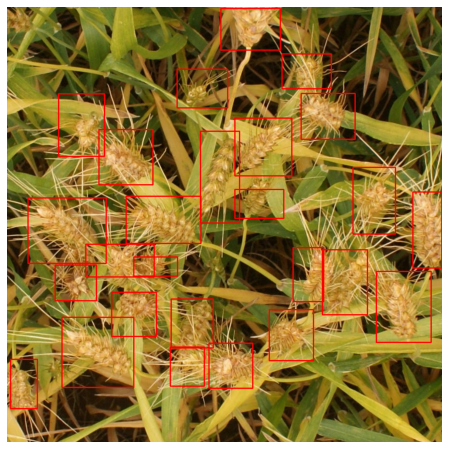

time: 483 ms


In [31]:
show_img(num,true_boxes)
#show_img(num,pred_boxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


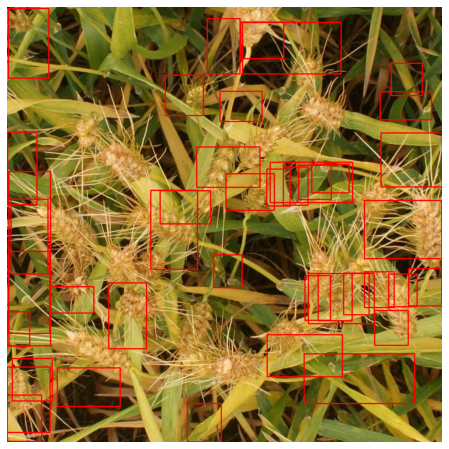

time: 494 ms


In [32]:
pred_boxes_conf = pred_boxes[confidences > 0.5]
show_img(num,pred_boxes_conf)
#show_img(num,pred_boxes)

In [33]:
pred_boxes_conf

tensor([[4.4640e+02, 3.2990e+02, 5.9577e+02, 4.2468e+02],
        [1.0951e-01, 9.1378e+02, 8.1204e+01, 1.0227e+03],
        [8.8099e+02, 2.9658e+02, 1.0240e+03, 4.2382e+02],
        [4.2481e+02, 9.3390e+02, 5.0486e+02, 1.0234e+03],
        [2.3949e+02, 6.4908e+02, 3.2846e+02, 8.0454e+02],
        [4.8635e+02, 5.8333e+02, 5.5377e+02, 6.6035e+02],
        [9.4597e+02, 6.1505e+02, 1.0234e+03, 7.0343e+02],
        [4.7142e+02, 2.7944e+01, 5.4829e+02, 1.5759e+02],
        [1.2995e+01, 8.2712e+02, 1.0634e+02, 9.2776e+02],
        [3.9938e+00, 3.1105e+00, 9.8364e+01, 1.6720e+02],
        [3.7208e+02, 1.6081e+02, 4.6229e+02, 2.5543e+02],
        [8.7870e+02, 1.9949e+02, 9.9943e+02, 2.6568e+02],
        [8.4173e+02, 4.5584e+02, 1.0239e+03, 5.9267e+02],
        [5.0109e+02, 1.9840e+02, 6.0008e+02, 2.6959e+02],
        [1.1892e+02, 8.4937e+02, 2.6630e+02, 9.4026e+02],
        [8.9818e+02, 6.2871e+02, 9.6581e+02, 7.0580e+02],
        [6.1263e+02, 7.7198e+02, 7.8936e+02, 8.7048e+02],
        [5.156

time: 6.81 ms


In [34]:
#boxes_pred = pred_boxes[confidences > threshold]
#confidences = confidences[confidences > threshold]

confidences = confidences.cpu()
pred_boxes = pred_boxes.cpu()
confidences = list(confidences)

time: 874 µs


In [35]:
#print('pred_boxes->',pred_boxes.shape)
#print('true_boxes->',true_boxes)
#print('confidences->',confidences)

time: 2.38 ms


In [36]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
# Load the trained weights
model.load_state_dict(torch.load('/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/fasterrcnn_resnet50_fpn.pth'))
model.eval()#x = model.to(device)

detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    #print('images->',images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

cuda
time: 853 ms


In [37]:
true_boxes

tensor([[ 121.,  204.,  229.,  351.],
        [ 216.,  288.,  343.,  418.],
        [  49.,  449.,  233.,  603.],
        [ 280.,  445.,  456.,  556.],
        [ 455.,  292.,  547.,  508.],
        [ 536.,  261.,  670.,  397.],
        [ 536.,  429.,  651.,  497.],
        [ 692.,  203.,  819.,  311.],
        [ 647.,  110.,  763.,  192.],
        [ 503.,    3.,  643.,  101.],
        [ 400.,  146.,  519.,  237.],
        [ 814.,  377.,  914.,  534.],
        [ 955.,  435., 1023.,  614.],
        [ 869.,  622.,  998.,  789.],
        [ 742.,  571.,  848.,  724.],
        [ 673.,  566.,  745.,  693.],
        [ 617.,  712.,  721.,  832.],
        [ 475.,  791.,  578.,  897.],
        [ 384.,  800.,  464.,  892.],
        [ 386.,  687.,  485.,  802.],
        [ 246.,  671.,  351.,  775.],
        [ 298.,  588.,  401.,  633.],
        [ 185.,  558.,  346.,  635.],
        [ 113.,  607.,  210.,  691.],
        [ 129.,  730.,  298.,  895.],
        [   8.,  829.,   71.,  945.]], dtype=torch

time: 4.8 ms


In [38]:
pred_boxes

tensor([[4.4640e+02, 3.2990e+02, 5.9577e+02, 4.2468e+02],
        [1.0951e-01, 9.1378e+02, 8.1204e+01, 1.0227e+03],
        [8.8099e+02, 2.9658e+02, 1.0240e+03, 4.2382e+02],
        [4.2481e+02, 9.3390e+02, 5.0486e+02, 1.0234e+03],
        [2.3949e+02, 6.4908e+02, 3.2846e+02, 8.0454e+02],
        [4.8635e+02, 5.8333e+02, 5.5377e+02, 6.6035e+02],
        [9.4597e+02, 6.1505e+02, 1.0234e+03, 7.0343e+02],
        [4.7142e+02, 2.7944e+01, 5.4829e+02, 1.5759e+02],
        [1.2995e+01, 8.2712e+02, 1.0634e+02, 9.2776e+02],
        [3.9938e+00, 3.1105e+00, 9.8364e+01, 1.6720e+02],
        [3.7208e+02, 1.6081e+02, 4.6229e+02, 2.5543e+02],
        [8.7870e+02, 1.9949e+02, 9.9943e+02, 2.6568e+02],
        [8.4173e+02, 4.5584e+02, 1.0239e+03, 5.9267e+02],
        [5.0109e+02, 1.9840e+02, 6.0008e+02, 2.6959e+02],
        [1.1892e+02, 8.4937e+02, 2.6630e+02, 9.4026e+02],
        [8.9818e+02, 6.2871e+02, 9.6581e+02, 7.0580e+02],
        [6.1263e+02, 7.7198e+02, 7.8936e+02, 8.7048e+02],
        [5.156

time: 9.84 ms


In [39]:
#confidences

time: 253 µs


In [40]:
#score = calculate_mean_precision(boxes_true=true_boxes, boxes_pred=pred_boxes, confidences=confidences)
score = mean_average_precision()
score

0.39408332668685736

time: 2.91 s


# Test precision

In [41]:
def test_calc_precision():
    boxes_true = torch.tensor([
        [0., 0., 10., 10.],     # GT1
        [0., 0., 12., 10.]      # GT2
    ])
    boxes_pred = torch.tensor([
        [0., 0., 0., 0.],      # P1
        [0., 0., 0., 0.],       # P2
        [0., 0., 10., 10.]
    ])
    confidences = [.5, .9]
    score = calculate_precision(boxes_true=boxes_true, boxes_pred=boxes_pred, confidences=confidences, threshold=.5)
    #assert score == 1.

    confidences = [.9, .5]
    score = calculate_precision(boxes_true=boxes_true, boxes_pred=boxes_pred, confidences=confidences, threshold=.5)
    #assert score == 1/3

    score = calculate_precision(boxes_true=boxes_true, boxes_pred=boxes_pred,
                                confidences=confidences, threshold=.5)
    print('test_calc_precision->',score)
    #assert score == 0

time: 2.09 ms


In [42]:
test_calc_precision()

test_calc_precision-> 0.25
time: 19.3 ms


# MAP

In [43]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

time: 4.66 ms


In [44]:
boxes

array([[ 945,  651, 1021,  749],
       [ 736,  894,  831,  977],
       [ 394,  796,  466,  883],
       [ 471,  359,  593,  451],
       [ 914,  885,  982,  977],
       [ 534,  868,  646,  985],
       [ 236,    0,  329,   61],
       [ 114,   39,  214,  109],
       [ 788,  735,  889,  805],
       [ 457,  497,  537,  632],
       [ 127,  846,  204,  918],
       [   1,  918,  106,  994],
       [ 733,  154,  814,  242],
       [ 479,   11,  548,   87],
       [ 113,  594,  244,  667],
       [   1,  739,   86,  839],
       [ 933,  775, 1014,  855],
       [ 455,  971,  552, 1023],
       [   5,    0,  100,   73],
       [ 988,  584, 1024,  674],
       [  85,    0,  221,   60],
       [ 889,   59,  995,  137],
       [ 429,   68,  539,  142],
       [ 438,  480,  499,  553],
       [   0,  264,   41,  354]], dtype=int32)

time: 1.7 ms


In [45]:
            #score = mean_average_precision(input_size=1024)


time: 1.45 ms
